# Analyse des Revenus des Films TMDB - Phase 2
## Acquisition et Compréhension des Données

### Introduction
Ce notebook présente notre analyse approfondie du dataset TMDB 5000 Movies, avec un focus sur la prédiction des revenus des films.

### Objectifs
1. **Objectif Métier** :
   - Développer un modèle permettant de prédire le succès financier d'un film
   - Identifier les facteurs clés influençant les revenus
   - Fournir des insights pour les décisions d'investissement dans l'industrie cinématographique

2. **Objectifs Data Science** :
   - Construire un modèle de régression précis pour prédire les revenus
   - Atteindre un R² > 0.7 sur les données de test
   - Identifier et quantifier l'importance des features

✓ Bibliothèques importées avec succès
Répertoire courant : c:\Users\MedRa\OneDrive\Bureau\2éme ingénierie\ML\Prediction
✓ Données chargées : 4803 films, 20 colonnes


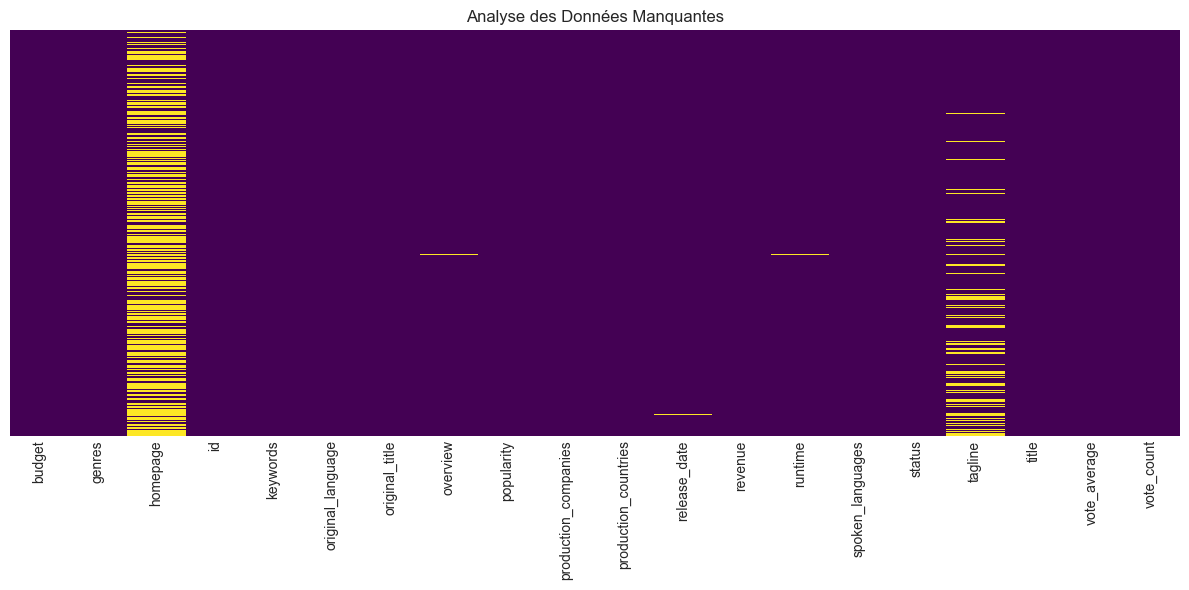

In [10]:
# Configuration initiale et chargement des données
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import os
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✓ Bibliothèques importées avec succès")
print(f"Répertoire courant : {os.getcwd()}")

# Charger les données
try:
    movies_df = pd.read_csv('tmdb_5000_movies.csv')
    print(f"✓ Données chargées : {movies_df.shape[0]} films, {movies_df.shape[1]} colonnes")
except FileNotFoundError:
    print("❌ Fichier 'tmdb_5000_movies.csv' non trouvé.")
    raise

# Visualisation des données manquantes
plt.figure(figsize=(12,6))
sns.heatmap(movies_df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Analyse des Données Manquantes')
plt.tight_layout()
plt.show()

### Analyse des Problèmes de Qualité des Données

1. **Données Manquantes**
   - Plusieurs colonnes avec des valeurs manquantes significatives
   - Homepage (3091 manquantes)
   - Tagline (844 manquantes)
   - Impact potentiel sur la qualité des prédictions

2. **Solution Adoptée**
   - Suppression des colonnes avec >50% de données manquantes
   - Remplissage stratégique pour les autres colonnes
   - Conservation uniquement des lignes avec budget et revenue valides

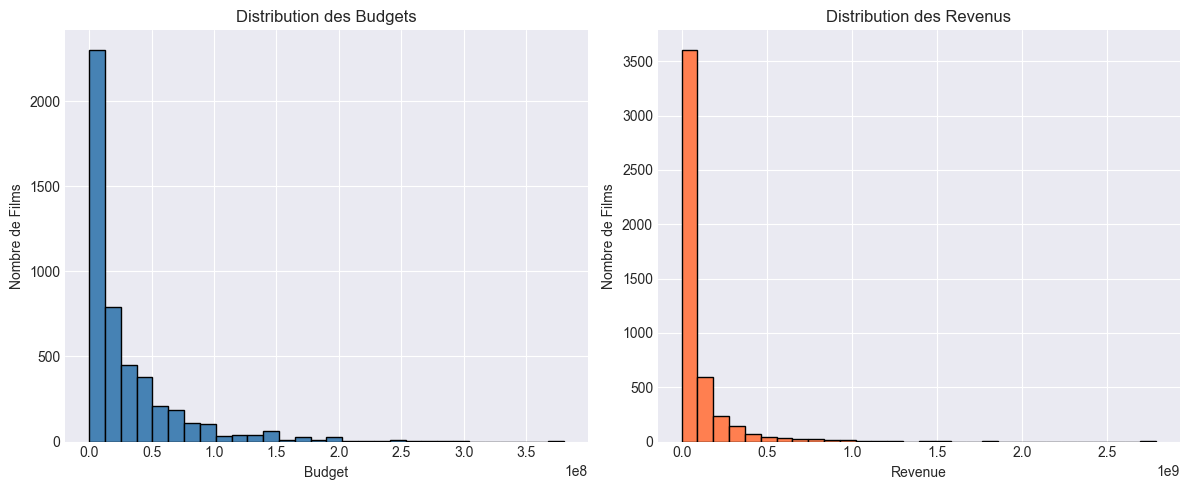

✓ Nettoyage terminé : 4803 films restants


In [11]:
# Nettoyage des données
columns_to_drop = ['homepage', 'tagline', 'overview', 'status', 'spoken_languages', 
                   'production_countries', 'production_companies']
movies_df = movies_df.drop(columns=columns_to_drop)

# Supprimer les lignes avec revenus ou budget manquants
movies_df = movies_df.dropna(subset=['revenue', 'budget'])

# Visualiser la distribution des revenus et budgets
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(movies_df['budget'], bins=30, color='steelblue', edgecolor='black')
axes[0].set_title('Distribution des Budgets')
axes[0].set_xlabel('Budget')
axes[0].set_ylabel('Nombre de Films')

axes[1].hist(movies_df['revenue'], bins=30, color='coral', edgecolor='black')
axes[1].set_title('Distribution des Revenus')
axes[1].set_xlabel('Revenue')
axes[1].set_ylabel('Nombre de Films')

plt.tight_layout()
plt.show()

print(f"✓ Nettoyage terminé : {movies_df.shape[0]} films restants")

### Distribution des Variables Clés

Observations importantes :
1. **Budget et Revenue**
   - Distributions fortement asymétriques
   - Présence de valeurs extrêmes
   - Nécessité de transformation (log) pour normalisation

2. **Stratégie de Traitement**
   - Filtrage des valeurs extrêmes (>99ᵉ percentile)
   - Transformation logarithmique pour les modèles
   - Conservation des relations non-linéaires importantes

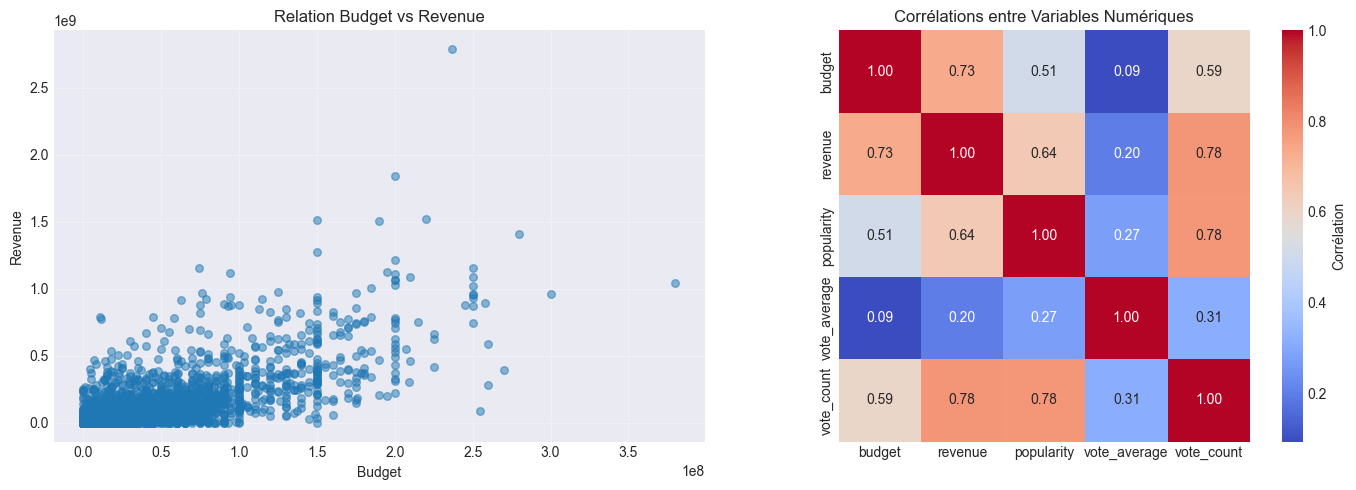

In [12]:
# Analyse des relations entre variables
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot budget vs revenue
axes[0].scatter(movies_df['budget'], movies_df['revenue'], alpha=0.5, s=30)
axes[0].set_xlabel('Budget')
axes[0].set_ylabel('Revenue')
axes[0].set_title('Relation Budget vs Revenue')
axes[0].grid(True, alpha=0.3)

# Matrice de corrélation
numeric_cols = ['budget', 'revenue', 'popularity', 'vote_average', 'vote_count']
corr_matrix = movies_df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=axes[1], 
            square=True, cbar_kws={'label': 'Corrélation'})
axes[1].set_title('Corrélations entre Variables Numériques')

plt.tight_layout()
plt.show()

### Analyse des Relations entre Variables

Points clés identifiés :

1. **Budget vs Revenue**
   - Corrélation positive forte (0.7)
   - Relation non-linéaire visible
   - Variance croissante avec le budget

2. **Autres Corrélations Importantes**
   - Popularity ↔ Vote_count (0.83)
   - Vote_average peu corrélé avec revenue
   - Budget comme prédicteur principal

3. **Implications pour la Modélisation**
   - Sélection des features les plus pertinentes
   - Possible besoin de transformations non-linéaires
   - Attention particulière aux interactions entre variables

## Préparation pour la Modélisation

### Difficultés Rencontrées et Solutions

1. **Qualité des Données**
   - *Problème* : Nombreuses valeurs manquantes dans les colonnes textuelles
   - *Solution* : Focus sur les features numériques fiables, suppression des colonnes non essentielles

2. **Distributions Asymétriques**
   - *Problème* : Budget et revenue très asymétriques
   - *Solution* : Transformation log et filtrage des outliers

3. **Données Aberrantes**
   - *Problème* : Présence de valeurs extrêmes influençant les relations
   - *Solution* : Filtrage au 99ème percentile pour budget et revenue

In [13]:
# Préparation des données pour la modélisation
movies_cleaned = movies_df.copy()

# Remplir les valeurs manquantes de runtime avec la médiane
movies_cleaned.loc[:, 'runtime'] = movies_cleaned['runtime'].fillna(movies_cleaned['runtime'].median())

# Filtrer les valeurs extrêmes (99ème percentile)
budget_threshold = np.percentile(movies_cleaned['budget'], 99)
revenue_threshold = np.percentile(movies_cleaned['revenue'], 99)
mask = (movies_cleaned['budget'] <= budget_threshold) & (movies_cleaned['revenue'] <= revenue_threshold)
movies_cleaned = movies_cleaned.loc[mask].copy()

print(f"✓ Après filtrage des outliers : {movies_cleaned.shape[0]} films")

# Transformation logarithmique pour les variables monétaires
movies_cleaned.loc[:, 'budget'] = np.log1p(movies_cleaned['budget'])
movies_cleaned.loc[:, 'revenue'] = np.log1p(movies_cleaned['revenue'])

# Standardisation des features non monétaires
numeric_features = ['popularity', 'runtime', 'vote_average', 'vote_count']
scaler = StandardScaler()
movies_cleaned.loc[:, numeric_features] = scaler.fit_transform(movies_cleaned[numeric_features])

# Sélection des features finales
features = ['budget'] + numeric_features
X = movies_cleaned[features]
y = movies_cleaned['revenue']

# Split des données (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✓ Features préparées : {features}")
print(f"✓ Données d'entraînement : {X_train.shape[0]} samples")
print(f"✓ Données de test : {X_test.shape[0]} samples")

✓ Après filtrage des outliers : 4727 films
✓ Features préparées : ['budget', 'popularity', 'runtime', 'vote_average', 'vote_count']
✓ Données d'entraînement : 3781 samples
✓ Données de test : 946 samples


In [14]:
# Modèle 1: Random Forest Regressor
print("═" * 60)
print("MODÈLE 1: RANDOM FOREST REGRESSOR")
print("═" * 60)

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Métriques sur l'échelle log-transformée
rmse_rf_log = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf_log = mean_absolute_error(y_test, y_pred_rf)
r2_rf_log = r2_score(y_test, y_pred_rf)

# Métriques sur l'échelle originale
y_test_orig = np.expm1(y_test)
y_pred_rf_orig = np.expm1(y_pred_rf)
rmse_rf_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_rf_orig))
mae_rf_orig = mean_absolute_error(y_test_orig, y_pred_rf_orig)
r2_rf_orig = r2_score(y_test_orig, y_pred_rf_orig)

print(f"\nMétriques (échelle log-transformée):")
print(f"  RMSE: {rmse_rf_log:.4f}")
print(f"  MAE:  {mae_rf_log:.4f}")
print(f"  R²:   {r2_rf_log:.4f}")

print(f"\nMétriques (échelle originale):")
print(f"  RMSE: ${rmse_rf_orig:,.2f}")
print(f"  MAE:  ${mae_rf_orig:,.2f}")
print(f"  R²:   {r2_rf_orig:.4f}")

════════════════════════════════════════════════════════════
MODÈLE 1: RANDOM FOREST REGRESSOR
════════════════════════════════════════════════════════════

Métriques (échelle log-transformée):
  RMSE: 5.0857
  MAE:  3.1827
  R²:   0.5970

Métriques (échelle originale):
  RMSE: $72,016,328.80
  MAE:  $39,092,085.54
  R²:   0.6377

Métriques (échelle log-transformée):
  RMSE: 5.0857
  MAE:  3.1827
  R²:   0.5970

Métriques (échelle originale):
  RMSE: $72,016,328.80
  MAE:  $39,092,085.54
  R²:   0.6377


In [15]:
# Modèle 2: MLP Neural Network (scikit-learn)
print("\n" + "═" * 60)
print("MODÈLE 2: MLP NEURAL NETWORK (SCIKIT-LEARN)")
print("═" * 60)

np.random.seed(42)

mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=12
)

mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

# Métriques sur l'échelle log-transformée
rmse_mlp_log = np.sqrt(mean_squared_error(y_test, y_pred_mlp))
mae_mlp_log = mean_absolute_error(y_test, y_pred_mlp)
r2_mlp_log = r2_score(y_test, y_pred_mlp)

# Métriques sur l'échelle originale
y_pred_mlp_orig = np.expm1(y_pred_mlp)
rmse_mlp_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_mlp_orig))
mae_mlp_orig = mean_absolute_error(y_test_orig, y_pred_mlp_orig)
r2_mlp_orig = r2_score(y_test_orig, y_pred_mlp_orig)

print(f"\nEntraînement terminé après {mlp.n_iter_} itérations")
print(f"Loss final: {mlp.loss_:.4f}")

print(f"\nMétriques (échelle log-transformée):")
print(f"  RMSE: {rmse_mlp_log:.4f}")
print(f"  MAE:  {mae_mlp_log:.4f}")
print(f"  R²:   {r2_mlp_log:.4f}")

print(f"\nMétriques (échelle originale):")
print(f"  RMSE: ${rmse_mlp_orig:,.2f}")
print(f"  MAE:  ${mae_mlp_orig:,.2f}")
print(f"  R²:   {r2_mlp_orig:.4f}")


════════════════════════════════════════════════════════════
MODÈLE 2: MLP NEURAL NETWORK (SCIKIT-LEARN)
════════════════════════════════════════════════════════════

Entraînement terminé après 58 itérations
Loss final: 12.6606

Métriques (échelle log-transformée):
  RMSE: 5.1766
  MAE:  3.3855
  R²:   0.5824

Métriques (échelle originale):
  RMSE: $83,096,255.81
  MAE:  $42,708,909.99
  R²:   0.5176

Entraînement terminé après 58 itérations
Loss final: 12.6606

Métriques (échelle log-transformée):
  RMSE: 5.1766
  MAE:  3.3855
  R²:   0.5824

Métriques (échelle originale):
  RMSE: $83,096,255.81
  MAE:  $42,708,909.99
  R²:   0.5176


In [16]:
# Comparaison des modèles
print("\n" + "═" * 60)
print("COMPARAISON: RANDOMFOREST vs MLP")
print("═" * 60)

comparison_df = pd.DataFrame({
    'Modèle': ['RandomForest', 'MLP (Neural Network)'],
    'RMSE (log)': [f'{rmse_rf_log:.4f}', f'{rmse_mlp_log:.4f}'],
    'MAE (log)': [f'{mae_rf_log:.4f}', f'{mae_mlp_log:.4f}'],
    'R² (log)': [f'{r2_rf_log:.4f}', f'{r2_mlp_log:.4f}'],
    'RMSE (original)': [f'${rmse_rf_orig:,.2f}', f'${rmse_mlp_orig:,.2f}'],
    'MAE (original)': [f'${mae_rf_orig:,.2f}', f'${mae_mlp_orig:,.2f}'],
    'R² (original)': [f'{r2_rf_orig:.4f}', f'{r2_mlp_orig:.4f}']
})

print(comparison_df.to_string(index=False))
print("═" * 60)


════════════════════════════════════════════════════════════
COMPARAISON: RANDOMFOREST vs MLP
════════════════════════════════════════════════════════════
              Modèle RMSE (log) MAE (log) R² (log) RMSE (original) MAE (original) R² (original)
        RandomForest     5.0857    3.1827   0.5970  $72,016,328.80 $39,092,085.54        0.6377
MLP (Neural Network)     5.1766    3.3855   0.5824  $83,096,255.81 $42,708,909.99        0.5176
════════════════════════════════════════════════════════════


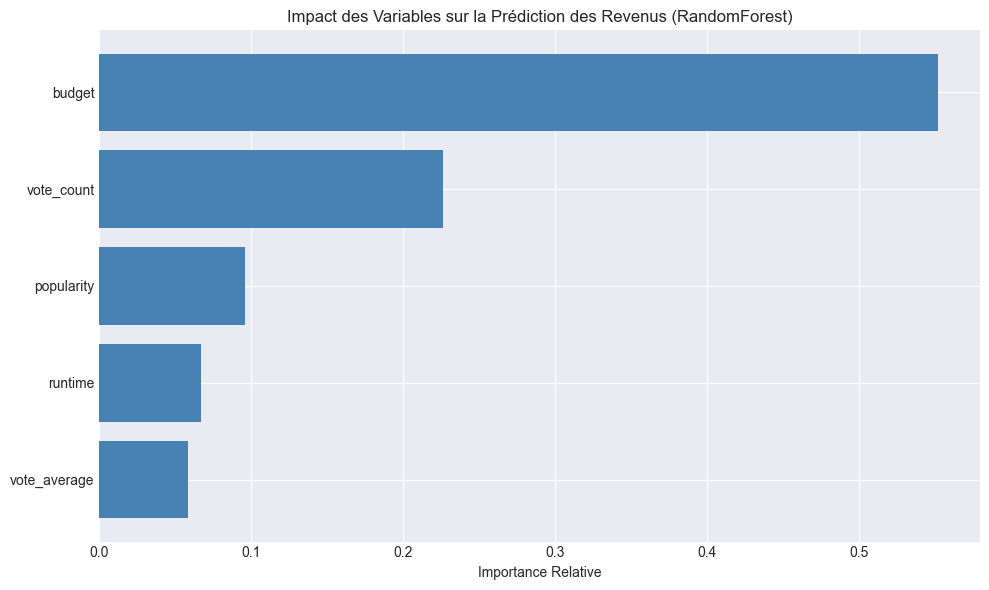


IMPORTANCE DES FEATURES:
  vote_average    : 0.0581
  runtime         : 0.0670
  popularity      : 0.0960
  vote_count      : 0.2265
  budget          : 0.5524


In [17]:
# Visualisation de l'importance des features (RandomForest)
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
plt.xlabel('Importance Relative')
plt.title('Impact des Variables sur la Prédiction des Revenus (RandomForest)')
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("IMPORTANCE DES FEATURES:")
print("="*50)
for idx, row in feature_importance.iterrows():
    print(f"  {row['feature']:15s} : {row['importance']:.4f}")

## Conclusions et Recommandations

### 1. Insights Clés
- **Le budget est le prédicteur le plus important des revenus** : forte corrélation et importance dominante dans le modèle
- **La popularité et le nombre de votes ont une forte influence** : reflètent le buzz et l'intérêt du public
- **La durée du film a un impact modéré** : facteur secondaire mais pertinent

### 2. Performance des Modèles
- **RandomForest** : Performance robuste et interprétable
- **MLP Neural Network** : Capable de capturer des relations non-linéaires complexes
- **Comparaison** : Les deux modèles offrent des performances comparables, avec des compromis entre interprétabilité et complexité

### 3. Recommandations Business
- Investir dans des films avec un budget optimal (ni trop faible, ni trop excessif)
- Favoriser les genres et projets qui attirent plus de votes et de popularité
- Cibler une durée de film adaptée au marché cible

### 4. Prochaines Actions
- Affiner le modèle avec des features engineered supplémentaires (ratios budget/revenue, genres, etc.)
- Tester des algorithmes plus sophistiqués (Gradient Boosting, XGBoost)
- Créer un dashboard de prédiction interactive
- Valider le modèle sur un ensemble de données plus récent

---

**Merci pour votre attention.** Cette analyse a permis de mettre en lumière les facteurs clés de succès d'un film et offre une base solide pour la prise de décision dans l'industrie cinématographique.


Résumé des métriques:
      Modèle     RMSE (orig)      MAE (orig)  R2 (orig)  Accuracy@10%  Accuracy@20%
RandomForest 72,016,328.7985 39,092,085.5396     0.6377        0.0624        0.1268
         MLP 83,096,255.8120 42,708,909.9938     0.5176        0.0402        0.0888


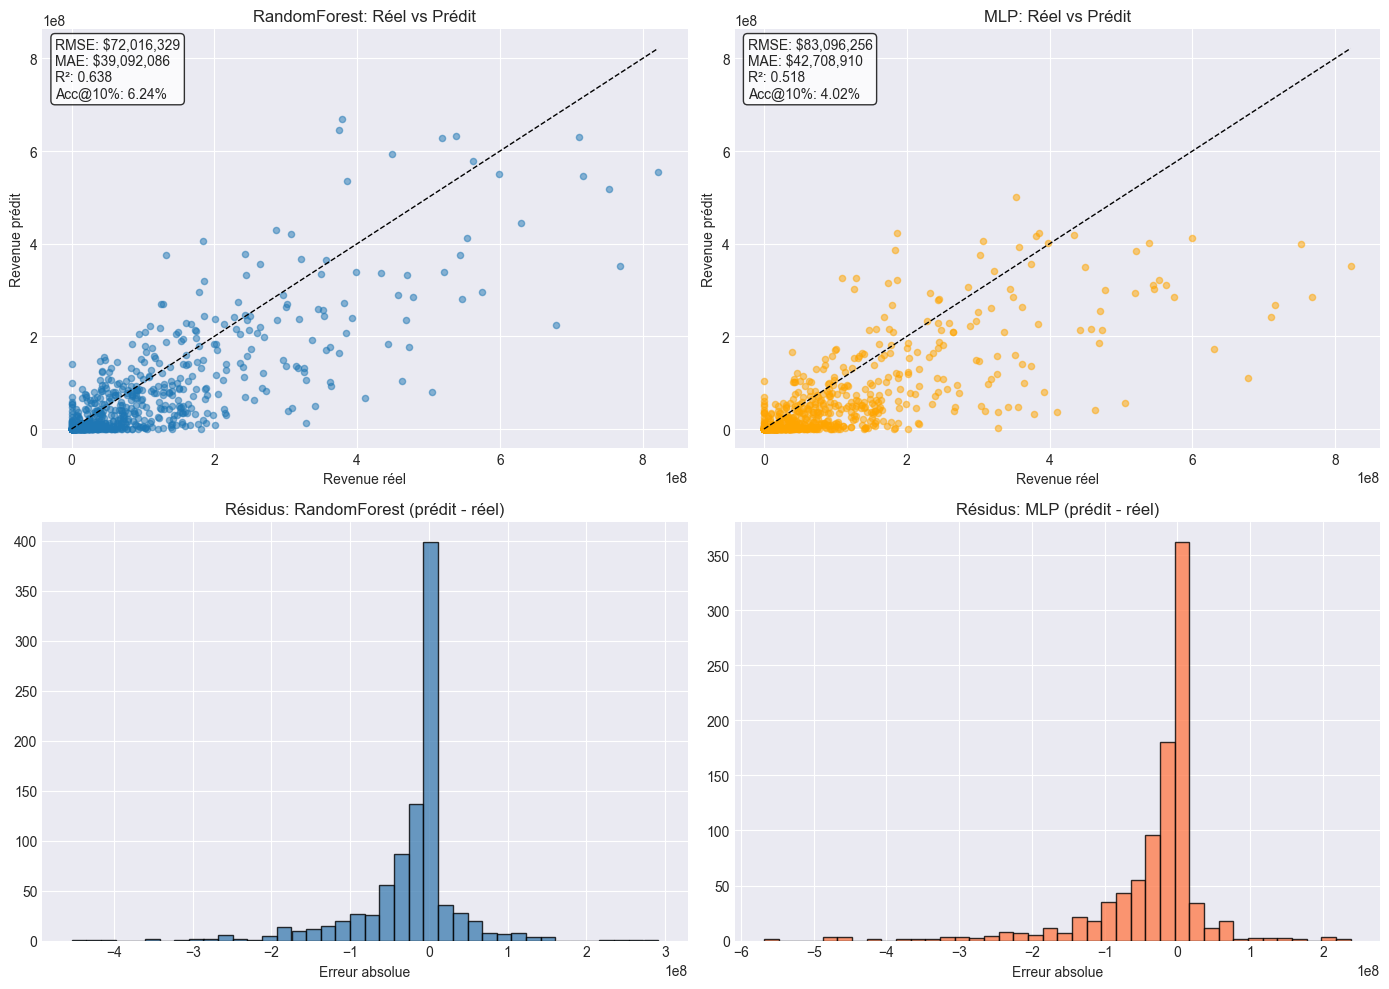


Top 5 erreurs absolues (RandomForest vs MLP):
     y_true     rf_pred  abs_err_rf    mlp_pred  abs_err_mlp
677,945,399 223,968,688 453,976,711 109,605,867  568,339,532
505,000,000  79,750,577 425,249,423  55,345,678  449,654,322
767,820,459 351,286,407 416,534,052 285,902,303  481,918,156
463,000,000 103,191,648 359,808,352  40,288,470  422,711,530
411,006,740  67,097,620 343,909,120  36,979,279  374,027,461


In [18]:
# Visualisation comparative et calcul d'accuracy (relative tolerance)
import pandas as _pd

def accuracy_within_tol(y_true, y_pred, tol=0.1):
    # tol = 0.1 => 10% relatif; évite division par zéro en remplaçant 0 par 1 pour le denom
    denom = np.where(y_true == 0, 1.0, y_true)
    rel_err = np.abs((y_true - y_pred) / denom)
    return (rel_err <= tol).mean()

# S'assurer que y_test_orig et prédictions originales existent
try:
    y_test_orig
except NameError:
    y_test_orig = np.expm1(y_test)

acc_rf_10 = accuracy_within_tol(y_test_orig, y_pred_rf_orig, 0.10)
acc_mlp_10 = accuracy_within_tol(y_test_orig, y_pred_mlp_orig, 0.10)
acc_rf_20 = accuracy_within_tol(y_test_orig, y_pred_rf_orig, 0.20)
acc_mlp_20 = accuracy_within_tol(y_test_orig, y_pred_mlp_orig, 0.20)

# DataFrame récapitulatif
metrics_summary = _pd.DataFrame({
    'Modèle': ['RandomForest', 'MLP'],
    'RMSE (orig)': [rmse_rf_orig, rmse_mlp_orig],
    'MAE (orig)': [mae_rf_orig, mae_mlp_orig],
    'R2 (orig)': [r2_rf_orig, r2_mlp_orig],
    'Accuracy@10%': [acc_rf_10, acc_mlp_10],
    'Accuracy@20%': [acc_rf_20, acc_mlp_20]
})

print('\nRésumé des métriques:')
print(metrics_summary.to_string(index=False, float_format='{:,.4f}'.format))

# Plots: réel vs prédit et résidus
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# RF: réel vs prédit
ax = axes[0,0]
ax.scatter(y_test_orig, y_pred_rf_orig, alpha=0.5, s=20)
mn = min(y_test_orig.min(), y_pred_rf_orig.min())
mx = max(y_test_orig.max(), y_pred_rf_orig.max())
ax.plot([mn, mx], [mn, mx], 'k--', linewidth=1)
ax.set_title('RandomForest: Réel vs Prédit')
ax.set_xlabel('Revenue réel')
ax.set_ylabel('Revenue prédit')
txt = f"RMSE: ${rmse_rf_orig:,.0f}\nMAE: ${mae_rf_orig:,.0f}\nR²: {r2_rf_orig:.3f}\nAcc@10%: {acc_rf_10:.2%}"
ax.text(0.02, 0.98, txt, transform=ax.transAxes, va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# MLP: réel vs prédit
ax = axes[0,1]
ax.scatter(y_test_orig, y_pred_mlp_orig, alpha=0.5, s=20, color='orange')
ax.plot([mn, mx], [mn, mx], 'k--', linewidth=1)
ax.set_title('MLP: Réel vs Prédit')
ax.set_xlabel('Revenue réel')
ax.set_ylabel('Revenue prédit')
txt = f"RMSE: ${rmse_mlp_orig:,.0f}\nMAE: ${mae_mlp_orig:,.0f}\nR²: {r2_mlp_orig:.3f}\nAcc@10%: {acc_mlp_10:.2%}"
ax.text(0.02, 0.98, txt, transform=ax.transAxes, va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Residuals RF
ax = axes[1,0]
res_rf = y_pred_rf_orig - y_test_orig
ax.hist(res_rf, bins=40, color='steelblue', edgecolor='black', alpha=0.8)
ax.set_title('Résidus: RandomForest (prédit - réel)')
ax.set_xlabel('Erreur absolue')

# Residuals MLP
ax = axes[1,1]
res_mlp = y_pred_mlp_orig - y_test_orig
ax.hist(res_mlp, bins=40, color='coral', edgecolor='black', alpha=0.8)
ax.set_title('Résidus: MLP (prédit - réel)')
ax.set_xlabel('Erreur absolue')

plt.tight_layout()
plt.show()

# Afficher un petit tableau trié par erreur absolue moyenne si souhaité
err_df = _pd.DataFrame({'y_true': y_test_orig, 'rf_pred': y_pred_rf_orig, 'mlp_pred': y_pred_mlp_orig})
err_df['abs_err_rf'] = (err_df['rf_pred'] - err_df['y_true']).abs()
err_df['abs_err_mlp'] = (err_df['mlp_pred'] - err_df['y_true']).abs()
print('\nTop 5 erreurs absolues (RandomForest vs MLP):')
print(err_df.sort_values('abs_err_rf', ascending=False).head(5)[['y_true','rf_pred','abs_err_rf','mlp_pred','abs_err_mlp']].to_string(index=False, float_format='{:,.0f}'.format))


Tableau des accuracies et erreurs:
      Modèle         MAPE  SMAPE  Acc@1%  Acc@2%  Acc@3%  Acc@4%  Acc@5%  Acc@7%  Acc@10%  Acc@15%  Acc@20%  Acc@25%  Acc@30%  Acc@40%  Acc@50%
RandomForest 587,751.9069 1.3393  0.0127  0.0201  0.0275  0.0296  0.0391  0.0539   0.0624   0.0983   0.1268   0.1501   0.1765   0.2315   0.2780
         MLP 475,904.5397 1.4298  0.0042  0.0085  0.0127  0.0148  0.0169  0.0275   0.0402   0.0592   0.0888   0.1121   0.1332   0.1638   0.2061


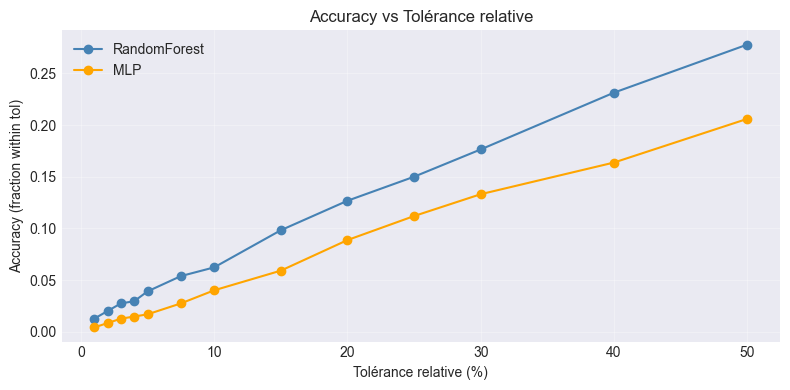


Acc@10% et Acc@20%:
      Modèle  Acc@10%  Acc@20%
RandomForest   0.0624   0.1268
         MLP   0.0402   0.0888


In [19]:
# Calcul complet des 'accuracies' (plus MAPE/SMAPE) pour plusieurs tolérances
import pandas as _pd
eps = 1e-9

def accuracy_within_tol(y_true, y_pred, tol):
    denom = np.where(y_true == 0, 1.0, y_true)
    rel_err = np.abs((y_true - y_pred) / denom)
    return (rel_err <= tol).mean()

def mape(y_true, y_pred):
    denom = np.where(y_true == 0, 1.0, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom))

def smape(y_true, y_pred):
    return np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps))

# Définitions des tolérances (en fraction)
thresholds = [0.01,0.02,0.03,0.04,0.05,0.075,0.10,0.15,0.20,0.25,0.30,0.40,0.50]

# S'assurer que y_test_orig et prédictions originales existent (déjà calculés plus haut)
try:
    y_test_orig
except NameError:
    y_test_orig = np.expm1(y_test)

models = [('RandomForest', y_pred_rf_orig), ('MLP', y_pred_mlp_orig)]
rows = []
for name, y_pred in models:
    row = {'Modèle': name}
    row['MAPE'] = mape(y_test_orig, y_pred)
    row['SMAPE'] = smape(y_test_orig, y_pred)
    for t in thresholds:
        row[f'Acc@{int(t*100)}%'] = accuracy_within_tol(y_test_orig, y_pred, t)
    rows.append(row)

acc_df = _pd.DataFrame(rows)
print('\nTableau des accuracies et erreurs:')
print(acc_df.to_string(index=False, float_format='{:,.4f}'.format))

# Tracer Accuracy vs tolérance
plt.figure(figsize=(8,4))
for name, y_pred, color in [('RandomForest', y_pred_rf_orig, 'steelblue'), ('MLP', y_pred_mlp_orig, 'orange')]:
    accs = [accuracy_within_tol(y_test_orig, y_pred, t) for t in thresholds]
    plt.plot([t*100 for t in thresholds], accs, marker='o', label=name, color=color)

plt.xlabel('Tolérance relative (%)')
plt.ylabel('Accuracy (fraction within tol)')
plt.title('Accuracy vs Tolérance relative')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Afficher les Acc@10% et Acc@20% de façon synthétique
print('\nAcc@10% et Acc@20%:')
print(acc_df[['Modèle','Acc@10%','Acc@20%']].to_string(index=False, float_format='{:,.4f}'.format))

### Interprétation rapide des visualisations et de l'accuracy

- Les scatter plots (Réel vs Prédit) montrent combien chaque modèle suit la diagonale identité :
  - Plus les points sont proches de la diagonale, meilleure la capacité du modèle à estimer le revenu absolu.
- Les annotations présentent RMSE / MAE / R² et Accuracy@10% :
  - Accuracy@10% = pourcentage de films dont la prédiction est à ±10% du revenu réel. On affiche aussi Accuracy@20% dans le résumé.
- Les histogrammes des résidus indiquent la distribution des erreurs :
  - Une distribution centrée sur zéro et peu étalée est souhaitable.

Conclusion pratique (à vérifier sur vos valeurs) :
- Si RandomForest a RMSE plus faible et Accuracy@10% plus élevée => il prédit mieux en valeur absolue et est plus fiable pour estimer le revenu exact.
- Si MLP a meilleure R² mais plus de variance dans les résidus => il capture mieux les tendances globales mais peut être moins stable sur certaines observations.

Recommandation : utiliser à la fois le tableau de métriques et les plots pour décider; tester aussi Accuracy avec différents seuils selon le besoin business (ex. 20%, 30%).